# Labolatorium 3

## Zadanie 1

Zaimplementuj (w postaci funkcji) sieć neuronową o architekturze przedstawionej na poniższym
rysunku.

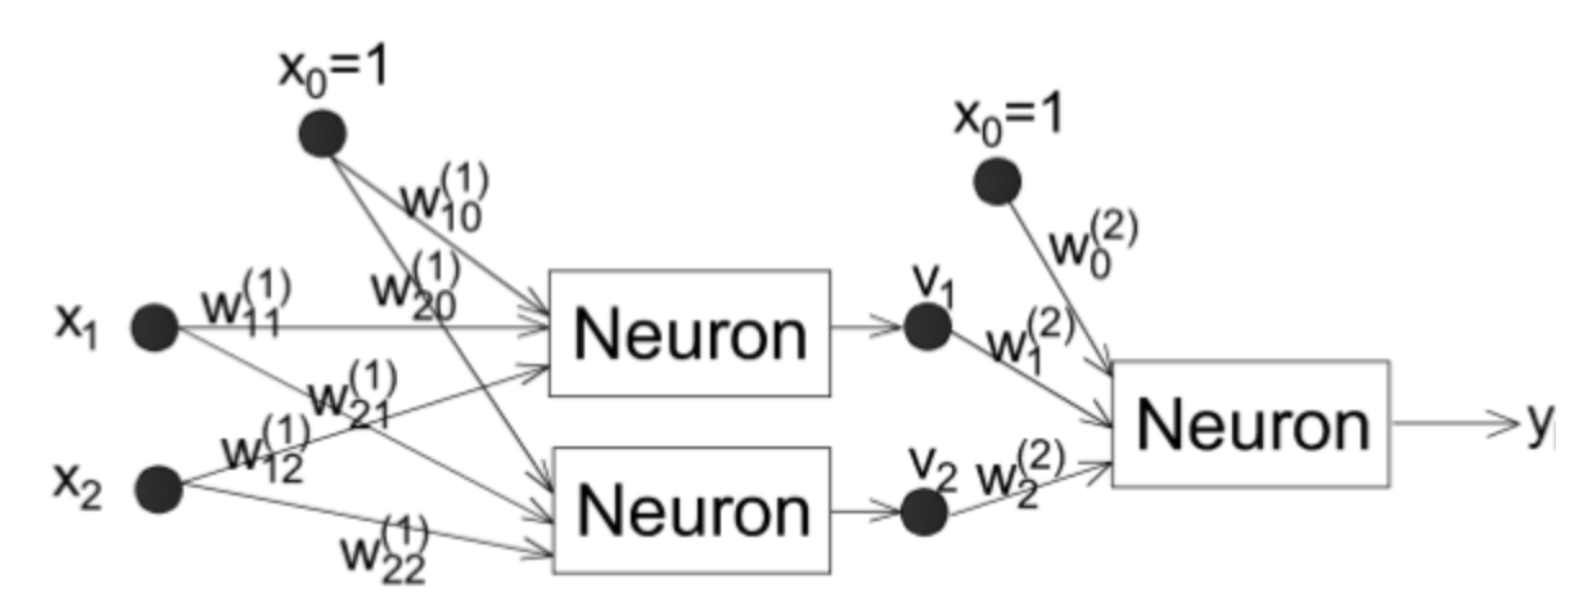

- Dla neuronów warstwy ukrytej jako funkcję aktywacji przyjmij bipolarną funkcję
sigmoidalną.
- Dla neuronu warstwy wyjściowej jako funkcję aktywacji przyjmij unipolarną funkcję
sigmoidalną.
- Implementację wykonaj na reprezentacji wektorowo-macierzowej.
- Funkcja powinna zwracać odpowiedź sieci oraz wszystkie składniki potrzebne do
obliczania pochodnych

Protips:
1. Zwróć uwagę, że wejściu dla warstwy wyjściowej jest .𝑥0=1
2. Można dodać do funkcji warunki sprawdzające poprawność wymiarów macierzy wag i
sygnałów wejściowych.
3. Do obliczenia pochodnych potrzebujemy wyjść warstwy ukrytej.



In [19]:
import numpy as np

def sigmoid(x, beta):
    return 1.0 / (1.0 + np.exp(-beta * x))

def tanh(x, beta):
    return np.tanh(beta * x)

# x - sygnał wejściowy [1, x1, x2, ..., xN]
# w1 - wagi warstwy ukrytej, macierz
# w2 - wagi warstwy wyjściowej, wektor
# beta - parametr funkcji aktywacji (lista: [beta_hidden, beta_output])
def mlp(x, w1, w2, beta):
    beta_hidden, beta_output = beta

    # Warstwa ukryta
    net_hidden = np.dot(w1, x) 
    v_hidden = tanh(net_hidden, beta_hidden)
    v_hidden_with_bias = np.concatenate(([1], v_hidden))

    # Warstwa wyjściowa
    net_output = np.dot(w2, v_hidden_with_bias)
    y = sigmoid(net_output, beta_output)

    return y, v_hidden, net_hidden, net_output

x = np.array([1, 0.5, -0.2])  # Wejście (z biasem x0=1)
w1 = np.array([[0.1, 0.2, -0.1],
               [0.3, -0.3, 0.5]])
w2 = np.array([0.4, -0.2, 0.1])
beta = [1.0, 1.0]

y, v_hidden, net_hidden, net_output = mlp(x, w1, w2, beta)
print("Wyjście sieci:", y)
print("Wyjścia warstwy ukrytej:", v_hidden)


Wyjście sieci: 0.5894500122484841
Wyjścia warstwy ukrytej: [0.21651806 0.04995837]


## Zadanie

Zaimplementuj algorytm wstecznej propagacji błędu dla sieci z poprzedniego zadania, stosując
dwa warianty aktualizacji wag:
- aktualizacja wag po każdej próbce uczącej,
- aktualizacja wag po każdej epoce (po przetworzeniu wszystkich próbek uczących).

Następnie stwórz wykres przedstawiający zmiany wartości błędu sieci podczas uczenia (w
zależności od epoki) dla problemu klasyfikacji XOR (dane podano poniżej).
Oba modele należy trenować aż do osiągnięcia błędu klasyfikacji równego 0 (lub maksymalnie
przez 100 000 epok), przy zastosowaniu następujących zasad klasyfikacji:
- jeśli wyjście sieci jest większe niż 0,9, uznajemy, że próbka należy do klasy 1,
- jeśli wyjście sieci jest mniejsze niż 0,1, uznajemy, że próbka należy do klasy 0,
- w pozostałych przypadkach uznajemy, że sieć nie zwraca jednoznacznej odpowiedzi.

Protips:
1. Aby zbyt często nie utykać w minimach lokalnych, warto zamienić zerowe sygnały
wejściowe na wartości niezerowe np. podane niżej dane uczące xx warto zamienić na
```python
    xx = np.array([[1,-1,-1],[1,-1,1],[1,1,-1],[1,1,1]]).
```
2. Zwróć uwagę, że wejściu dla warstwy wyjściowej jest - przy liczeniu gradientu𝑥0=1
należy “odciąć” bias i pobrać wartości wyjść tylko neuronów warstwy ukrytej.
3. Gradient dla warstwy ukrytej powinien mieć rozmiar (2,1).
4. Przy aktualizacji wag po każdej epoce należy aktualizować wagi na podstawie
skumulowanych gradientów.

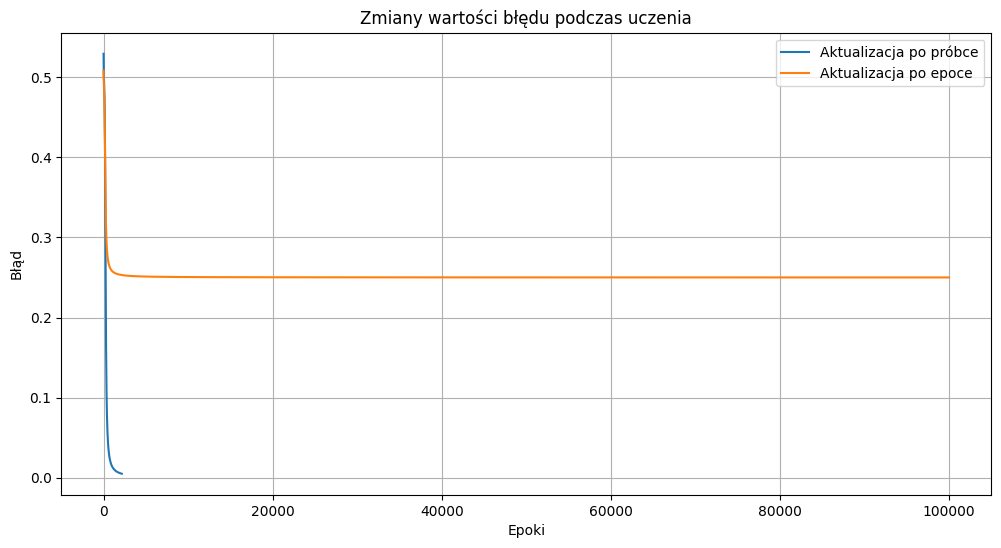

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x, beta):
    return 1.0 / (1.0 + np.exp(-beta * x))

def sigmoid_diff(y, beta):
    return beta * y * (1 - y)

def tanh(x, beta):
    return np.tanh(beta * x)

def tanh_diff(y, beta):
    return beta * (1 - y**2)

xx = np.array([[1, -1, -1], [1, -1, 1], [1, 1, -1], [1, 1, 1]])
d = np.array([0, 1, 1, 0])

def train_sample(xx, d, w1, w2, eta, beta):
    beta_hidden, beta_output = beta
    
    for x, target in zip(xx, d):
        y, v_hidden, net_hidden, net_output = mlp(x, w1, w2, beta)
        
        error_output = target - y
        delta_output = error_output * sigmoid_diff(y, beta_output)
        
        # Backpropagation dla warstwy ukrytej
        delta_hidden = delta_output * w2[1:] * tanh_diff(v_hidden, beta_hidden)
        
        # Aktualizacja wag
        w2 += eta * delta_output * np.concatenate(([1], v_hidden))
        w1 += eta * np.outer(delta_hidden, x)
    
    return w1, w2

def train_epoch(xx, d, w1, w2, eta, beta):
    beta_hidden, beta_output = beta
    grad_w2 = np.zeros_like(w2)
    grad_w1 = np.zeros_like(w1)
    
    for x, target in zip(xx, d):
        y, v_hidden, net_hidden, net_output = mlp(x, w1, w2, beta)
        
        error_output = target - y
        delta_output = error_output * sigmoid_diff(y, beta_output)
        
        # Backpropagation dla warstwy ukrytej
        delta_hidden = delta_output * w2[1:] * tanh_diff(v_hidden, beta_hidden)
        
        # Sumowanie gradientów
        grad_w2 += delta_output * np.concatenate(([1], v_hidden))
        grad_w1 += np.outer(delta_hidden, x)
    
    # Aktualizacja wag po całej epoce
    w2 += eta * grad_w2
    w1 += eta * grad_w1
    
    return w1, w2

def train_network(xx, d, eta, beta, epochs=100000, threshold=0.01):
    np.random.seed(42)
    w1 = np.random.uniform(-0.5, 0.5, (2, 3))
    w2 = np.random.uniform(-0.5, 0.5, 3)
    
    errors_sample = []
    errors_epoch = []
    
    # Aktualizacja wag po każdej próbce
    for epoch in range(epochs):
        w1, w2 = train_sample(xx, d, w1, w2, eta, beta)
        
        error = 0
        for x, target in zip(xx, d):
            y, _, _, _ = mlp(x, w1, w2, beta)
            error += (target - y)**2
        errors_sample.append(error / 2)
        
        if error < threshold:
            break
    
    w1 = np.random.uniform(-0.5, 0.5, (2, 3))
    w2 = np.random.uniform(-0.5, 0.5, 3)
    
    # Aktualizacja wag po każdej epoce
    for epoch in range(epochs):
        w1, w2 = train_epoch(xx, d, w1, w2, eta, beta)
        
        error = 0
        for x, target in zip(xx, d):
            y, _, _, _ = mlp(x, w1, w2, beta)
            error += (target - y)**2
        errors_epoch.append(error / 2)
        
        if error < threshold:
            break
    
    return errors_sample, errors_epoch, epoch

eta = 0.1
beta = [1.0, 1.0]
epochs = 100000

errors_sample, errors_epoch, final_epoch = train_network(xx, d, eta, beta, epochs)

plt.figure(figsize=(12, 6))
plt.plot(errors_sample, label="Aktualizacja po próbce")
plt.plot(errors_epoch, label="Aktualizacja po epoce")
plt.xlabel("Epoki")
plt.ylabel("Błąd")
plt.title("Zmiany wartości błędu podczas uczenia")
plt.legend()
plt.grid()
plt.show()
